# Topics Notebook

In [244]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alaynemoody/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [245]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

In [253]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [248]:
# Import Dataset
df = pd.read_csv("20201117_AM_Sentiment.csv") 
df.head()

,Unnamed: 0,Sentence,fileid,Sequence,Sentiment
0,0,baltimore 20 september 1836 dear heinrich: fr...,S10003-D023.txt,1,0.7263
1,1,it was a long and arduous voyage!,S10003-D023.txt,2,0.0000
2,2,however we were and are all well and thank the...,S10003-D023.txt,3,0.8777
3,3,i had written down the events of the voyage fo...,S10003-D023.txt,4,0.2263
4,4,"as you know, we set sail on 12 july.",S10003-D023.txt,5,0.0000


In [249]:
df['Sentence'].count()

44025

In [250]:
# Convert to list
data = df.Sentence.values.tolist()
data[:5]

[' baltimore 20 september 1836 dear heinrich: friday evening, 16 september, anchor was dropped and we had safely arrived in the harbor!',
 'it was a long and arduous voyage!',
 'however we were and are all well and thank the father in heaven that he has protected us so far!',
 'i had written down the events of the voyage for you, but to my great annoyance i am now missing the whole notebook; perhaps i will find it later.',
 'as you know, we set sail on 12 july.']

In [251]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'was', 'dropped', 'and', 'we', 'had', 'safely', 'arrived', 'in', 'the', 'harbor'], ['it', 'was', 'long', 'and', 'arduous', 'voyage'], ['however', 'we', 'were', 'and', 'are', 'all', 'well', 'and', 'thank', 'the', 'father', 'in', 'heaven', 'that', 'he', 'has', 'protected', 'us', 'so', 'far'], ['had', 'written', 'down', 'the', 'events', 'of', 'the', 'voyage', 'for', 'you', 'but', 'to', 'my', 'great', 'annoyance', 'am', 'now', 'missing', 'the', 'whole', 'notebook', 'perhaps', 'will', 'find', 'it', 'later'], ['as', 'you', 'know', 'we', 'set', 'sail', 'on', 'july']]


In [281]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [282]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [283]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [284]:
print(data_words_nostops[:100])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'father', 'heaven', 'protected', 'us', 'far'], ['written', 'events', 'voyage', 'great', 'annoyance', 'missing', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['know', 'set', 'sail', 'july'], ['afternoon', 'pilot', 'left', 'us', 'one', 'began', 'hold', 'head', 'overboard', 'bernhard', 'mrs', 'schwarze', 'children', 'others'], ['next', 'morning', 'felt', 'ill', 'remained', 'bed', 'two', 'days', 'whole', 'time', 'vomit', 'four', 'five', 'times', 'pretty', 'much', 'passengers'], ['later', 'always', 'spared'], ['wind', 'adverse', 'first', 'evening', 'remained', 'almost', 'three', 'weeks', 'pass', 'english', 'channel', 'august', 'cope', 'heavy', 'stormy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'went', 'fine', 'beginning', 'later', 'sailed', 'southward', 'experienced', 'calm', 'grea

In [285]:
print(data_words_bigrams[:100])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'father', 'heaven', 'protected', 'us', 'far'], ['written', 'events', 'voyage', 'great', 'annoyance', 'missing', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['know', 'set', 'sail', 'july'], ['afternoon', 'pilot', 'left', 'us', 'one', 'began', 'hold', 'head', 'overboard', 'bernhard', 'mrs', 'schwarze', 'children', 'others'], ['next', 'morning', 'felt', 'ill', 'remained', 'bed', 'two', 'days', 'whole', 'time', 'vomit', 'four', 'five', 'times', 'pretty', 'much', 'passengers'], ['later', 'always', 'spared'], ['wind', 'adverse', 'first', 'evening', 'remained', 'almost', 'three', 'weeks', 'pass', 'english', 'channel', 'august', 'cope', 'heavy', 'stormy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'went', 'fine', 'beginning', 'later', 'sailed', 'southward', 'experienced', 'calm', 'grea

In [286]:
print(data_lemmatized[:100])

[['evening', 'anchor', 'drop', 'safely', 'arrive', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'protect', 'far'], ['write', 'event', 'voyage', 'great', 'annoyance', 'miss', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['set', 'sail'], ['afternoon', 'pilot', 'leave', 'begin', 'hold', 'head', 'overboard', 'child', 'other'], ['next', 'morning', 'feel', 'ill', 'remained', 'bed', 'day', 'whole', 'time', 'vomit', 'time', 'pretty', 'much', 'passenger'], ['later', 'always', 'spare'], ['wind', 'adverse', 'first', 'evening', 'remain', 'almost', 'week', 'pass', 'cope', 'heavy', 'stormy', 'weather'], ['sea', 'thing', 'go', 'fine', 'beginning', 'later', 'sail', 'southward', 'experience', 'calm', 'great', 'heat'], ['longing', 'reach', 'land', 'soon', 'possible', 'become', 'great', 'great'], ['water', 'bad', 'food', 'appetize', 'good', 'ham', 'sufficient', 'wine'], ['lot', 'thing', 'lack'], ['pity', 'other', 'dine', 'also', 'heat', 'great', 'sit'], ['scarcely', 'shade'

In [287]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [288]:
# View
corpus[:3]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]

In [289]:
id2word[7]

'long'

In [120]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('choice', 1),
  ('congratulate', 1),
  ('destination', 1),
  ('fatherland', 1),
  ('give', 1),
  ('impression', 1),
  ('judge', 1),
  ('last', 1),
  ('may', 1),
  ('permit', 1),
  ('reason', 1),
  ('second', 1),
  ('shall', 1),
  ('short', 1),
  ('stay', 1)],
 [('last', 1),
  ('beg', 1),
  ('burn_mid', 1),
  ('continue', 1),
  ('day', 1),
  ('description', 1),
  ('detail', 2),
  ('eleventh', 1),
  ('enter', 1),
  ('faithful_diary', 1),
  ('follow', 1),
  ('help', 1),
  ('indulgence', 1),
  ('make', 1),
  ('month', 1),
  ('night', 1),
  ('oil', 1),
  ('read', 1),
  ('thread', 1)]]

In [136]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500, # How many sentences trained at a time
                                           passes=5,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [137]:
# Print the keywords for 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"tell" + 0.027*"shall" + 0.027*"let" + 0.026*"dear" + 0.017*"wish" + '
  '0.014*"food" + 0.013*"always" + 0.013*"immigrant" + 0.011*"settle" + '
  '0.011*"thank"'),
 (1,
  '0.022*"would" + 0.022*"come" + 0.019*"make" + 0.018*"may" + 0.018*"time" + '
  '0.018*"well" + 0.018*"see" + 0.018*"year" + 0.015*"say" + 0.014*"know"'),
 (2,
  '0.032*"man" + 0.031*"people" + 0.031*"many" + 0.028*"country" + '
  '0.022*"great" + 0.013*"child" + 0.013*"call" + 0.013*"give" + 0.013*"state" '
  '+ 0.012*"part"'),
 (3,
  '0.022*"family" + 0.018*"kind" + 0.018*"bad" + 0.017*"church" + '
  '0.013*"woman" + 0.011*"horse" + 0.010*"school" + 0.010*"hold" + '
  '0.010*"cost" + 0.010*"farmer"'),
 (4,
  '0.023*"go" + 0.023*"day" + 0.021*"good" + 0.020*"work" + 0.017*"much" + '
  '0.015*"get" + 0.014*"find" + 0.013*"little" + 0.013*"land" + 0.011*"long"')]


In [138]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.955042555706178

Coherence Score:  0.39947605655181234


In [48]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.258332  0.054723       1        1  33.563667
4     -0.246476  0.020060       2        1  30.786499
2      0.106846 -0.364506       3        1  17.749294
3      0.201874  0.210167       4        1   9.543619
0      0.196087  0.079555       5        1   8.356920, topic_info=     Category         Freq         Term        Total  loglift  logprob
142   Default  3802.000000          man  3802.000000  30.0000  30.0000
272   Default  3718.000000       people  3718.000000  29.0000  29.0000
312   Default  3976.000000         many  3976.000000  28.0000  28.0000
376   Default  3312.000000      country  3312.000000  27.0000  27.0000
256   Default  4756.000000           go  4756.000000  26.0000  26.0000
309   Default  4887.000000        would  4887.000000  25.0000  25.0000
219   Default  4869.000000         come  4869.000000  24.0000  24.0000
18    Default  4870.000000          day  4870.000000  23.0000  23.0000
90    Default  4031.000000         work  4031.000000  22.0000  22.0000
155   Default  2656.000000        great  2656.000000  21.0000  21.0000
8     Default  4087.000000          may  4087.000000  20.0000  20.0000
27    Default  4189.000000         make  4189.000000  19.0000  19.0000
102   Default  4086.000000         time  4086.000000  18.0000  18.0000
278   Default  1756.000000         tell  1756.000000  17.0000  17.0000
638   Default  4003.000000          see  4003.000000  16.0000  16.0000
702   Default  3990.000000         year  3990.000000  15.0000  15.0000
286   Default  3404.000000         much  3404.000000  14.0000  14.0000
323   Default  5076.000000         good  5076.000000  13.0000  13.0000
12    Default  1499.000000        shall  1499.000000  12.0000  12.0000
281   Default  1498.000000          let  1498.000000  11.0000  11.0000
400   Default  3410.000000          say  3410.000000  10.0000  10.0000
857   Default  3148.000000          get  3148.000000   9.0000   9.0000
1561  Default  1463.000000         dear  1463.000000   8.0000   8.0000
267   Default  4411.000000         well  4411.000000   7.0000   7.0000
333   Default  3148.000000         know  3148.000000   6.0000   6.0000
56    Default  3034.000000        could  3034.000000   5.0000   5.0000
84    Default  2891.000000         find  2891.000000   4.0000   4.0000
2079  Default  1448.000000       family  1448.000000   3.0000   3.0000
1204  Default  2927.000000        think  2927.000000   2.0000   2.0000
115   Default  2621.000000       little  2621.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
12     Topic5  1498.317993        shall  1499.230713   2.4815  -3.6165
281    Topic5  1497.552734          let  1498.466187   2.4815  -3.6170
1561   Topic5  1462.112793         dear  1463.021729   2.4815  -3.6409
1914   Topic5   935.417297         wish   936.327393   2.4811  -4.0876
1624   Topic5   753.820129         food   754.751221   2.4808  -4.3034
1365   Topic5   726.990112       always   727.901611   2.4808  -4.3397
2920   Topic5   709.615906    immigrant   710.554077   2.4808  -4.3639
2438   Topic5   613.744080       settle   614.656921   2.4806  -4.5090
1480   Topic5   609.722656        thank   610.637939   2.4806  -4.5156
1577   Topic5   602.128174   employment   603.051819   2.4805  -4.5281
3796   Topic5   589.996155    sometimes   590.910889   2.4805  -4.5485
1414   Topic5   548.587952         walk   549.502441   2.4804  -4.6212
1685   Topic5   477.720673       parent   478.634033   2.4802  -4.7596
383    Topic5   425.107666     building   426.025574   2.4799  -4.8762
1768   Topic5   377.150055     remember   378.062317   2.4797  -4.9959
467    Topic5   379.873352     thousand   380.798309   2.4796  -4.9887
499    Topic5   374.285065       employ   375.202484   2.4796  -5.0036
4029   Topic5   373.743988        blood   374.677002   2.4796  -5.0050
1229   Topic5   364.457062  o

Twenty-four topics in three categories from Moreton (2016):
<ol>
    <b>High-frequency, structural topics</b>
<li>Previous letters</li>
<li>Future letters</li>
<li>Greetings</li>
<li>Salutations</li>
<li>Signoff</li>
<li>Weather</li>
    <b>High-frequency, non-structural topics</b>
<li>Ireland/America (i.e., homeland)</li>
<li>Family/friends</li>
<li>Religion</li>
<li>Recollections</li>
<li>Homesickness/separation</li>
<li>Health/illness</li>
<li>Work</li>
<li>Enclosures</li>
<li>Remittances</li>
    <b>Low-frequency, intimate/personal topics</b>
<li>News/events</li>
<li>Reunification</li>
<li>Death</li>
<li>Daily life</li>
<li>Writing process</li>
<li>Identity</li>
<li>Education</li>
<li>Migration</li>
<li>Transportation</li>
<ol>

In [121]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [ ]:
# Run model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=24, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [351]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [294]:
len(model_list)

24

In [295]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=27, step=1)

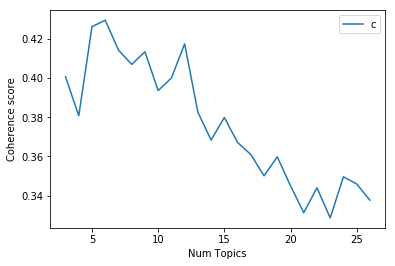

In [296]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [297]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4006
Num Topics = 4  has Coherence Value of 0.3808
Num Topics = 5  has Coherence Value of 0.4262
Num Topics = 6  has Coherence Value of 0.4295
Num Topics = 7  has Coherence Value of 0.4142
Num Topics = 8  has Coherence Value of 0.407
Num Topics = 9  has Coherence Value of 0.4134
Num Topics = 10  has Coherence Value of 0.3936
Num Topics = 11  has Coherence Value of 0.4
Num Topics = 12  has Coherence Value of 0.4174
Num Topics = 13  has Coherence Value of 0.3825
Num Topics = 14  has Coherence Value of 0.3683
Num Topics = 15  has Coherence Value of 0.3798
Num Topics = 16  has Coherence Value of 0.3671
Num Topics = 17  has Coherence Value of 0.361
Num Topics = 18  has Coherence Value of 0.3501
Num Topics = 19  has Coherence Value of 0.3598
Num Topics = 20  has Coherence Value of 0.345
Num Topics = 21  has Coherence Value of 0.3312
Num Topics = 22  has Coherence Value of 0.3439
Num Topics = 23  has Coherence Value of 0.3286
Num Topics = 24  has Coher

In [322]:
# Coherence for 12-topic model
coherence_values[9]

0.4174186134262747

In [324]:
# Topics for 12-topic model
malletModel_12 = model_list[9]
model_topics_12 = malletModel_12.show_topics(formatted=False)
pprint(malletModel_12.print_topics(num_words=5))

[(0,
  '0.052*"dear" + 0.046*"give" + 0.039*"sister" + 0.033*"friend" + '
  '0.028*"love"'),
 (1,
  '0.071*"man" + 0.067*"good" + 0.057*"child" + 0.038*"family" + 0.038*"live"'),
 (2,
  '0.041*"year" + 0.039*"land" + 0.035*"house" + 0.022*"country" + '
  '0.021*"water"'),
 (3,
  '0.026*"place" + 0.023*"country" + 0.021*"state" + 0.020*"town" + '
  '0.019*"mile"'),
 (4,
  '0.098*"day" + 0.043*"home" + 0.038*"leave" + 0.030*"back" + 0.028*"begin"'),
 (5,
  '0.060*"find" + 0.049*"thing" + 0.043*"great" + 0.040*"feel" + 0.035*"hope"'),
 (6,
  '0.074*"work" + 0.049*"good" + 0.042*"year" + 0.037*"money" + '
  '0.035*"dollar"'),
 (7,
  '0.027*"large" + 0.024*"small" + 0.018*"pass" + 0.018*"high" + '
  '0.017*"place"'),
 (8,
  '0.053*"people" + 0.032*"life" + 0.021*"make" + 0.017*"speak" + '
  '0.017*"mind"'),
 (9,
  '0.106*"time" + 0.083*"write" + 0.082*"letter" + 0.058*"long" + '
  '0.042*"receive"'),
 (10,
  '0.038*"make" + 0.036*"bring" + 0.024*"school" + 0.023*"call" + '
  '0.018*"follow"

In [327]:
# Coherence for 6-topic model
coherence_values[3]

0.4294848491898951

In [329]:
# Topics for 6-topic model
malletModel_06 = model_list[3]
model_topics_06 = malletModel_06.show_topics(formatted=False)
pprint(malletModel_06.print_topics(num_words=5))

[(0,
  '0.037*"work" + 0.031*"make" + 0.030*"find" + 0.027*"place" + 0.026*"great"'),
 (1,
  '0.054*"time" + 0.051*"day" + 0.029*"long" + 0.028*"leave" + 0.022*"home"'),
 (2,
  '0.036*"man" + 0.019*"family" + 0.016*"life" + 0.014*"call" + 0.014*"young"'),
 (3,
  '0.045*"good" + 0.041*"write" + 0.041*"letter" + 0.038*"give" + '
  '0.032*"send"'),
 (4,
  '0.018*"house" + 0.017*"bring" + 0.012*"hand" + 0.011*"water" + '
  '0.010*"room"'),
 (5,
  '0.041*"year" + 0.022*"country" + 0.019*"land" + 0.017*"dollar" + '
  '0.017*"pay"')]


In [332]:
# Coherence for 9-topic model
coherence_values[6]

0.413370382730252

In [333]:
# Topics for 9-topic model
malletModel_09 = model_list[6]
model_topics_09 = malletModel_09.show_topics(formatted=False)
pprint(malletModel_09.print_topics(num_words=10))

[(0,
  '0.062*"year" + 0.046*"good" + 0.034*"live" + 0.033*"country" + 0.029*"land" '
  '+ 0.026*"house" + 0.025*"mile" + 0.020*"part" + 0.014*"farm" + '
  '0.014*"sell"'),
 (1,
  '0.053*"man" + 0.042*"child" + 0.033*"home" + 0.029*"feel" + 0.028*"family" '
  '+ 0.024*"life" + 0.021*"wife" + 0.021*"young" + 0.020*"mother" + '
  '0.017*"poor"'),
 (2,
  '0.076*"make" + 0.056*"work" + 0.036*"thing" + 0.028*"money" + '
  '0.027*"dollar" + 0.026*"pay" + 0.024*"month" + 0.023*"place" + 0.017*"good" '
  '+ 0.015*"winter"'),
 (3,
  '0.017*"night" + 0.017*"large" + 0.015*"room" + 0.013*"stand" + 0.012*"cold" '
  '+ 0.012*"fall" + 0.012*"city" + 0.011*"open" + 0.011*"hand" + 0.010*"side"'),
 (4,
  '0.027*"find" + 0.026*"bring" + 0.019*"small" + 0.017*"good" + 0.016*"water" '
  '+ 0.015*"fine" + 0.013*"high" + 0.012*"put" + 0.012*"foot" + 0.012*"grow"'),
 (5,
  '0.074*"day" + 0.032*"week" + 0.021*"return" + 0.021*"call" + 0.019*"arrive" '
  '+ 0.018*"leave" + 0.016*"morning" + 0.015*"hour" + 0.01

In [334]:
mallet2ldaModel_12 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(malletModel_12)

In [342]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet2ldaModel_12, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.180157  0.131460       1        1  8.545564
7     -0.227976 -0.203693       2        1  8.497906
3     -0.219996 -0.176961       3        1  8.394330
6     -0.054377  0.283363       4        1  8.390464
10    -0.058462 -0.028891       5        1  8.379442
8      0.036850  0.026119       6        1  8.317883
11     0.133312 -0.097975       7        1  8.287977
4     -0.011530  0.012864       8        1  8.260720
1      0.014916  0.245710       9        1  8.259014
5      0.170176 -0.003315      10        1  8.242561
0      0.218705 -0.127766      11        1  8.238812
9      0.178539 -0.060916      12        1  8.185327, topic_info=     Category         Freq       Term        Total  loglift  logprob
45    Default  2761.000000       time  2761.000000  30.0000  30.0000
36    Default  2578.000000        day  2578.000000  29.0000  29.0000
78    Default  3051.000000       good  3051.000000  28.0000  28.0000
23    Default  2145.000000      write  2145.000000  27.0000  27.0000
215   Default  2118.000000     letter  2118.000000  26.0000  26.0000
271   Default  1958.000000       work  1958.000000  25.0000  25.0000
694   Default  1865.000000        man  1865.000000  24.0000  24.0000
16    Default  1577.000000       find  1577.000000  23.0000  23.0000
353   Default  2262.000000       year  2262.000000  22.0000  22.0000
7     Default  1503.000000       long  1503.000000  21.0000  21.0000
28    Default  1480.000000      child  1480.000000  20.0000  20.0000
172   Default  1388.000000     people  1388.000000  19.0000  19.0000
725   Default  1371.000000       dear  1371.000000  18.0000  18.0000
177   Default  2796.000000       make  2796.000000  17.0000  17.0000
68    Default  1274.000000      thing  1274.000000  16.0000  16.0000
214   Default  2042.000000       give  2042.000000  15.0000  15.0000
435   Default  1685.000000       send  1685.000000  14.0000  14.0000
182   Default  1133.000000       home  1133.000000  13.0000  13.0000
98    Default  1103.000000    receive  1103.000000  12.0000  12.0000
37    Default  1038.000000       feel  1038.000000  11.0000  11.0000
70    Default  1046.000000       land  1046.000000  10.0000  10.0000
222   Default  1026.000000     sister  1026.000000   9.0000   9.0000
17    Default  1404.000000      great  1404.000000   8.0000   8.0000
795   Default   997.000000     family   997.000000   7.0000   7.0000
1152  Default   985.000000      money   985.000000   6.0000   6.0000
357   Default  1244.000000       live  1244.000000   5.0000   5.0000
756   Default   944.000000      bring   944.000000   4.0000   4.0000
263   Default   945.000000      house   945.000000   3.0000   3.0000
31    Default  1427.000000      leave  1427.000000   2.0000   2.0000
440   Default   941.000000     dollar   941.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
432   Topic12   159.792351    forward   159.792351   2.5028  -5.0898
585   Topic12   157.235673    address   157.235673   2.5028  -5.1059
340   Topic12   145.730624  satisfied   145.730624   2.5028  -5.1819
1135  Topic12   138.060591    writing   138.060591   2.5028  -5.2360
4047  Topic12   123.998864   japanese   123.998864   2.5028  -5.3434
1063  Topic12   108.658798        pen   108.658798   2.5028  -5.4755
210   Topic12   106.102121   tomorrow   106.102121   2.5028  -5.4993
1746  Topic12    93.318733  important    93.318733   2.5028  -5.6277
1584  Topic12    86.927039    enclose    86.927039   2.5028  -5.6986
321   Topic12    83.092022      delay    83.092022   2.5028  -5.7437
1424  Topic12    77.978667     remind    77.978667   2.5028  -5.8073
4701  Topic12    72.865312      stamp    72.865312   2.5028  -5.8751
2706  Topic12    69.030296   birthday    69.030296   2.5028  -5.9291
1665  Topic12    67.751957      ahead    67.751957   2.5028  -5.9478
437   Topic12   123.998864      uncle   1

In [345]:
mallet2ldaModel_06 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(malletModel_06)

In [346]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet2ldaModel_06, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.214836  0.045222       1        1  17.012826
4     -0.317829 -0.093044       2        1  16.837491
0      0.018711  0.250755       3        1  16.717691
2      0.153987 -0.296435       4        1  16.553716
3      0.168428 -0.137987       5        1  16.448805
1      0.191540  0.231490       6        1  16.429471, topic_info=     Category         Freq       Term        Total  loglift  logprob
45    Default  2809.000000       time  2809.000000  30.0000  30.0000
36    Default  2636.000000        day  2636.000000  29.0000  29.0000
23    Default  2140.000000      write  2140.000000  28.0000  28.0000
78    Default  3023.000000       good  3023.000000  27.0000  27.0000
353   Default  2256.000000       year  2256.000000  26.0000  26.0000
215   Default  2113.000000     letter  2113.000000  25.0000  25.0000
271   Default  1974.000000       work  1974.000000  24.0000  24.0000
214   Default  2017.000000       give  2017.000000  23.0000  23.0000
694   Default  1867.000000        man  1867.000000  22.0000  22.0000
177   Default  2771.000000       make  2771.000000  21.0000  21.0000
435   Default  1681.000000       send  1681.000000  20.0000  20.0000
16    Default  1564.000000       find  1564.000000  19.0000  19.0000
7     Default  1529.000000       long  1529.000000  18.0000  18.0000
31    Default  1451.000000      leave  1451.000000  17.0000  17.0000
324   Default  1448.000000      place  1448.000000  16.0000  16.0000
17    Default  1395.000000      great  1395.000000  15.0000  15.0000
172   Default  1380.000000     people  1380.000000  14.0000  14.0000
725   Default  1366.000000       dear  1366.000000  13.0000  13.0000
202   Default  1201.000000    country  1201.000000  12.0000  12.0000
182   Default  1159.000000       home  1159.000000  11.0000  11.0000
58    Default  1123.000000       week  1123.000000  10.0000  10.0000
98    Default  1100.000000    receive  1100.000000   9.0000   9.0000
222   Default  1043.000000     sister  1043.000000   8.0000   8.0000
70    Default  1045.000000       land  1045.000000   7.0000   7.0000
28    Default  1466.000000      child  1466.000000   6.0000   6.0000
68    Default  1270.000000      thing  1270.000000   5.0000   5.0000
795   Default   998.000000     family   998.000000   4.0000   4.0000
357   Default  1245.000000       live  1245.000000   3.0000   3.0000
263   Default   950.000000      house   950.000000   2.0000   2.0000
440   Default   938.000000     dollar   938.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
27     Topic6   744.102880      begin   744.102880   1.8061  -4.2482
193    Topic6   706.377384    brother   706.377384   1.8061  -4.3003
168    Topic6   794.837167       back   796.112621   1.8045  -4.1823
55     Topic6   628.324634     remain   628.324634   1.8061  -4.4174
143    Topic6   597.103535      night   597.103535   1.8061  -4.4683
39     Topic6   555.475401    morning   555.475401   1.8061  -4.5406
76     Topic6   525.555181        bad   525.555181   1.8061  -4.5960
175    Topic6   496.935839       stay   496.935839   1.8061  -4.6520
362    Topic6   442.298915       cold   442.298915   1.8061  -4.7684
73     Topic6   434.493640      reach   434.493640   1.8061  -4.7862
352    Topic6   422.785727       turn   422.785727   1.8061  -4.8136
164    Topic6   385.060231       wait   385.060231   1.8061  -4.9070
407    Topic6   379.856715     change   379.856715   1.8061  -4.9206
1416   Topic6   373.352319       rest   373.352319   1.8061  -4.9379
153    Topic6   351.237373       move   351.237373   1.8061  -4.9990
1001   Topic6   347.334736      short   347.334736   1.8061  -5.0101
521    Topic6   330.423307    company   330.423307   1.8061  -5.0601
341    Topic6   320.016273      today   320.016273   1.8061  -5.0921
775    Topic6   312.210998       fear   312.210998   1.8061  -5.1167
1056  

In [347]:
mallet2ldaModel_09 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(malletModel_09)

In [348]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet2ldaModel_09, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.126732  0.254993       1        1  11.349990
0      0.208255  0.005310       2        1  11.321599
6      0.173147 -0.204501       3        1  11.167575
3      0.008260  0.246735       4        1  11.147319
2      0.199197 -0.132741       5        1  11.087330
5     -0.181038  0.138982       6        1  11.020680
1     -0.123169 -0.126663       7        1  10.995502
8     -0.160965 -0.107926       8        1  10.976628
7     -0.250418 -0.074189       9        1  10.933377, topic_info=      Category         Freq        Term        Total  loglift  logprob
36     Default  2590.000000         day  2590.000000  30.0000  30.0000
177    Default  2769.000000        make  2769.000000  29.0000  29.0000
45     Default  2829.000000        time  2829.000000  28.0000  28.0000
353    Default  2253.000000        year  2253.000000  27.0000  27.0000
23     Default  2128.000000       write  2128.000000  26.0000  26.0000
215    Default  2101.000000      letter  2101.000000  25.0000  25.0000
214    Default  2005.000000        give  2005.000000  24.0000  24.0000
271    Default  1978.000000        work  1978.000000  23.0000  23.0000
694    Default  1857.000000         man  1857.000000  22.0000  22.0000
435    Default  1671.000000        send  1671.000000  21.0000  21.0000
7      Default  1545.000000        long  1545.000000  20.0000  20.0000
28     Default  1473.000000       child  1473.000000  19.0000  19.0000
78     Default  3039.000000        good  3039.000000  18.0000  18.0000
172    Default  1377.000000      people  1377.000000  17.0000  17.0000
725    Default  1358.000000        dear  1358.000000  16.0000  16.0000
68     Default  1265.000000       thing  1265.000000  15.0000  15.0000
357    Default  1231.000000        live  1231.000000  14.0000  14.0000
202    Default  1199.000000     country  1199.000000  13.0000  13.0000
182    Default  1145.000000        home  1145.000000  12.0000  12.0000
58     Default  1125.000000        week  1125.000000  11.0000  11.0000
98     Default  1094.000000     receive  1094.000000  10.0000  10.0000
70     Default  1044.000000        land  1044.000000   9.0000   9.0000
37     Default  1023.000000        feel  1023.000000   8.0000   8.0000
222    Default  1017.000000      sister  1017.000000   7.0000   7.0000
1152   Default   995.000000       money   995.000000   6.0000   6.0000
795    Default   992.000000      family   992.000000   5.0000   5.0000
17     Default  1389.000000       great  1389.000000   4.0000   4.0000
324    Default  1448.000000       place  1448.000000   3.0000   3.0000
440    Default   951.000000      dollar   951.000000   2.0000   2.0000
263    Default   943.000000       house   943.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
276     Topic9   231.245617     service   231.245617   2.2133  -5.0097
196     Topic9   285.115334     trouble   286.401535   2.2088  -4.8003
1267    Topic9   176.062004     opinion   176.062004   2.2133  -5.2823
606     Topic9   174.748108        pray   174.748108   2.2133  -5.2898
743     Topic9   161.609152       agree   161.609152   2.2133  -5.3680
174     Topic9   160.295257     realize   160.295257   2.2133  -5.3762
1494    Topic9   157.667466       story   157.667466   2.2133  -5.3927
14048   Topic9   156.353570   norwegian   156.353570   2.2133  -5.4010
1540    Topic9   155.039675       reply   155.039675   2.2133  -5.4095
367     Topic9   249.640154   situation   250.916592   2.2082  -4.9331
340     Topic9   149.784093   satisfied   149.784093   2.2133  -5.4440
995     Topic9   137.959033    strength   137.959033   2.2133  -5.5262
674     Topic9   134.017346        past   134.017346   2.2133  -5.5552
544     Topic9   132.703450    progress   132.703450   2.2133  -5.5651
521     Topic9   328.473887     company   333.656876   2.1977  -4.6587
342     Topic9   290.37091

In [354]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_umass = []
    model_list_umass = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_umass.append(model)
        coherencemodel_umass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values_umass.append(coherencemodel_umass.get_coherence())

    return model_list_umass, coherence_values_umass

In [356]:
# Can take a long time to run.
model_list_umass, coherence_values_umass = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=27, step=1)

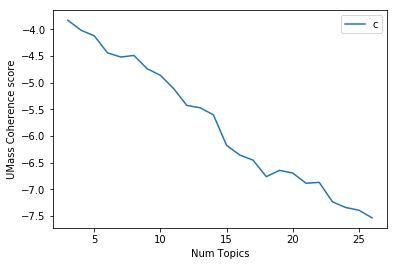

In [357]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_umass)
plt.xlabel("Num Topics")
plt.ylabel("UMass Coherence score")
plt.legend(("coherence_values_umass"), loc='best')
plt.show()

In [305]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=mallet2ldaModel10, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1176,"water, foot, stand, cold, fall, turn, open, be...",baltimore 20 september 1836 dear heinrich: fr...
1,1,7.0,0.0914,"write, letter, time, send, long, hear, receive...",it was a long and arduous voyage!
2,2,4.0,0.0950,"give, place, order, state, follow, case, meet,...",however we were and are all well and thank the...
3,3,9.0,0.0973,"leave, thing, find, home, feel, friend, make, ...",i had written down the events of the voyage fo...
4,4,4.0,0.0977,"give, place, order, state, follow, case, meet,...","as you know, we set sail on 12 july."
5,5,6.0,0.1002,"day, week, mile, return, night, morning, room,...","by the afternoon, when the pilot left us, one ..."
6,6,6.0,0.1450,"day, week, mile, return, night, morning, room,...",the next morning i felt ill and remained in be...
7,7,9.0,0.0942,"leave, thing, find, home, feel, friend, make, ...",later i was always spared.
8,8,3.0,0.1332,"water, foot, stand, cold, fall, turn, open, be...",the wind was adverse from the very first eveni...
9,9,2.0,0.0974,"good, people, life, live, present, hope, perso...",on the open sea things went fine in the beginn...


In [164]:
map_sentenceText_topicNumber = {}

In [165]:
for index, item in enumerate(data):
    topic_dist = model.get_document_topics(corpus[index])

    # topic_dist is a list of tuples: each tuple has a topic number with its corresponding proportion
    sorted_topic_dist = sorted(topic_dist, key=lambda x: (x[1]), reverse=True) # Sort it in descending order
    
    # Pick the top one:
    topic_number = sorted_topic_dist[0][0]
    map_sentenceText_topicNumber[item] = topic_number

In [166]:
map_sentenceText_topicNumber

{' San Francisco, Jan 29th, 1852.': 0,
 'At last I am at my destination and, if I may be permitted to judge from the impression which the short stay has given me, I shall have reason to congratulate myself upon the choice of my second fatherland.': 3,
 'But before I enter into details about San Francisco — details which will make you burn mid-night oil to read — I beg your indulgence for a brief space while continuing my last description — with the help of my faithful diary — the thread of which you followed to the eleventh day of this month.': 3,
 'The twelfth brought various indications of near-by land, such as the dark-green color of the water, diving ducks (duckers, as the sailors commonly call them), gray birds about the size of our geese.': 1,
 'There also appeared floating alongside of our boat the limb of a tree, covered with leaves, a most convincing and welcome proof that the days of our journey were numbered.': 2,
 'At about a quarter to one, the same afternoon, the joyous s

In [168]:
df['topicNumber'] = df['Sentence'].map(map_sentenceText_topicNumber)

In [169]:
df

,Unnamed: 0,Sentence,fileid,Sentiment,topicNumber
0,0,"San Francisco, Jan 29th, 1852.",S8552-D007.txt,0.0000,0
1,1,"At last I am at my destination and, if I may b...",S8552-D007.txt,0.6249,3
2,2,But before I enter into details about San Fran...,S8552-D007.txt,0.6808,3
3,3,The twelfth brought various indications of nea...,S8552-D007.txt,0.0772,1
4,4,There also appeared floating alongside of our ...,S8552-D007.txt,0.7397,2
5,5,"At about a quarter to one, the same afternoon,...",S8552-D007.txt,0.7096,1
6,6,Soon after we commenced to notice the outlines...,S8552-D007.txt,0.0000,4
7,7,The sea grew calmer and the air warmer.,S8552-D007.txt,0.5719,2
8,8,"As darkness set in we, of course, lost sight o...",S8552-D007.txt,-0.5106,0
9,9,By four o'clock the next morning we found ours...,S8552-D007.txt,0.8479,2


In [170]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4386,"make, day, work, place, house, money, man, beg...",I could fill this letter with names and lives ...
1,1.0,0.5987,"good, find, dollar, mile, land, year, bring, p...","For your amusement, here's a typical week's me..."
2,2.0,0.5365,"long, city, part, large, small, water, foot, h...","Oatmeal, Indian meal, and rice, when boiled as..."
3,3.0,0.5040,"time, give, letter, write, send, home, leave, ...",The generality of Irishmen who swarm in and ab...
4,4.0,0.5114,"man, people, great, year, child, life, country...","The cause of most of the crime, poverty, idlen..."


In [196]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

0.0    22196
3.0    17160
1.0    16449
2.0    13793
4.0    13332
Name: Dominant_Topic, dtype: int64

In [203]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

0.0    0.2676
3.0    0.2069
1.0    0.1983
2.0    0.1663
4.0    0.1608
Name: Dominant_Topic, dtype: float64

In [214]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by = 'Dominant_Topic')
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,1.0,"good, find, dollar, mile, land, year, bring, p..."
4,2.0,"long, city, part, large, small, water, foot, h..."
1,3.0,"time, give, letter, write, send, home, leave, ..."
6,4.0,"man, people, great, year, child, life, country..."


In [215]:
topic_num_keywords.reset_index(drop=True, inplace=True)
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
4,4.0,"man, people, great, year, child, life, country..."


In [216]:
topic_num_keywords = topic_num_keywords.reindex([0,3,1,2,4])
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
4,4.0,"man, people, great, year, child, life, country..."


In [227]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.rename('counts'), topic_contribution.rename('contribution')], axis=1).sort_values(by = 'Dominant_Topic')
df_dominant_topics

,Dominant_Topic,Topic_Keywords,counts,contribution
0,0.0,"make, day, work, place, house, money, man, beg...",22196,0.2676
1,1.0,"good, find, dollar, mile, land, year, bring, p...",16449,0.1983
2,2.0,"long, city, part, large, small, water, foot, h...",13793,0.1663
3,3.0,"time, give, letter, write, send, home, leave, ...",17160,0.2069
4,4.0,"man, people, great, year, child, life, country...",13332,0.1608
